**Analysis and Preprocessing of the data**

In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import r2_score

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv("/content/drive/MyDrive/CW1_train.csv")
df.head()

print("Original shape:", df.shape)

Original shape: (10000, 31)


In [6]:
df = df.dropna()

print("New shape:", df.shape)

New shape: (10000, 31)


Visualising Outliers (Red = Outlier, Blue = Normal)


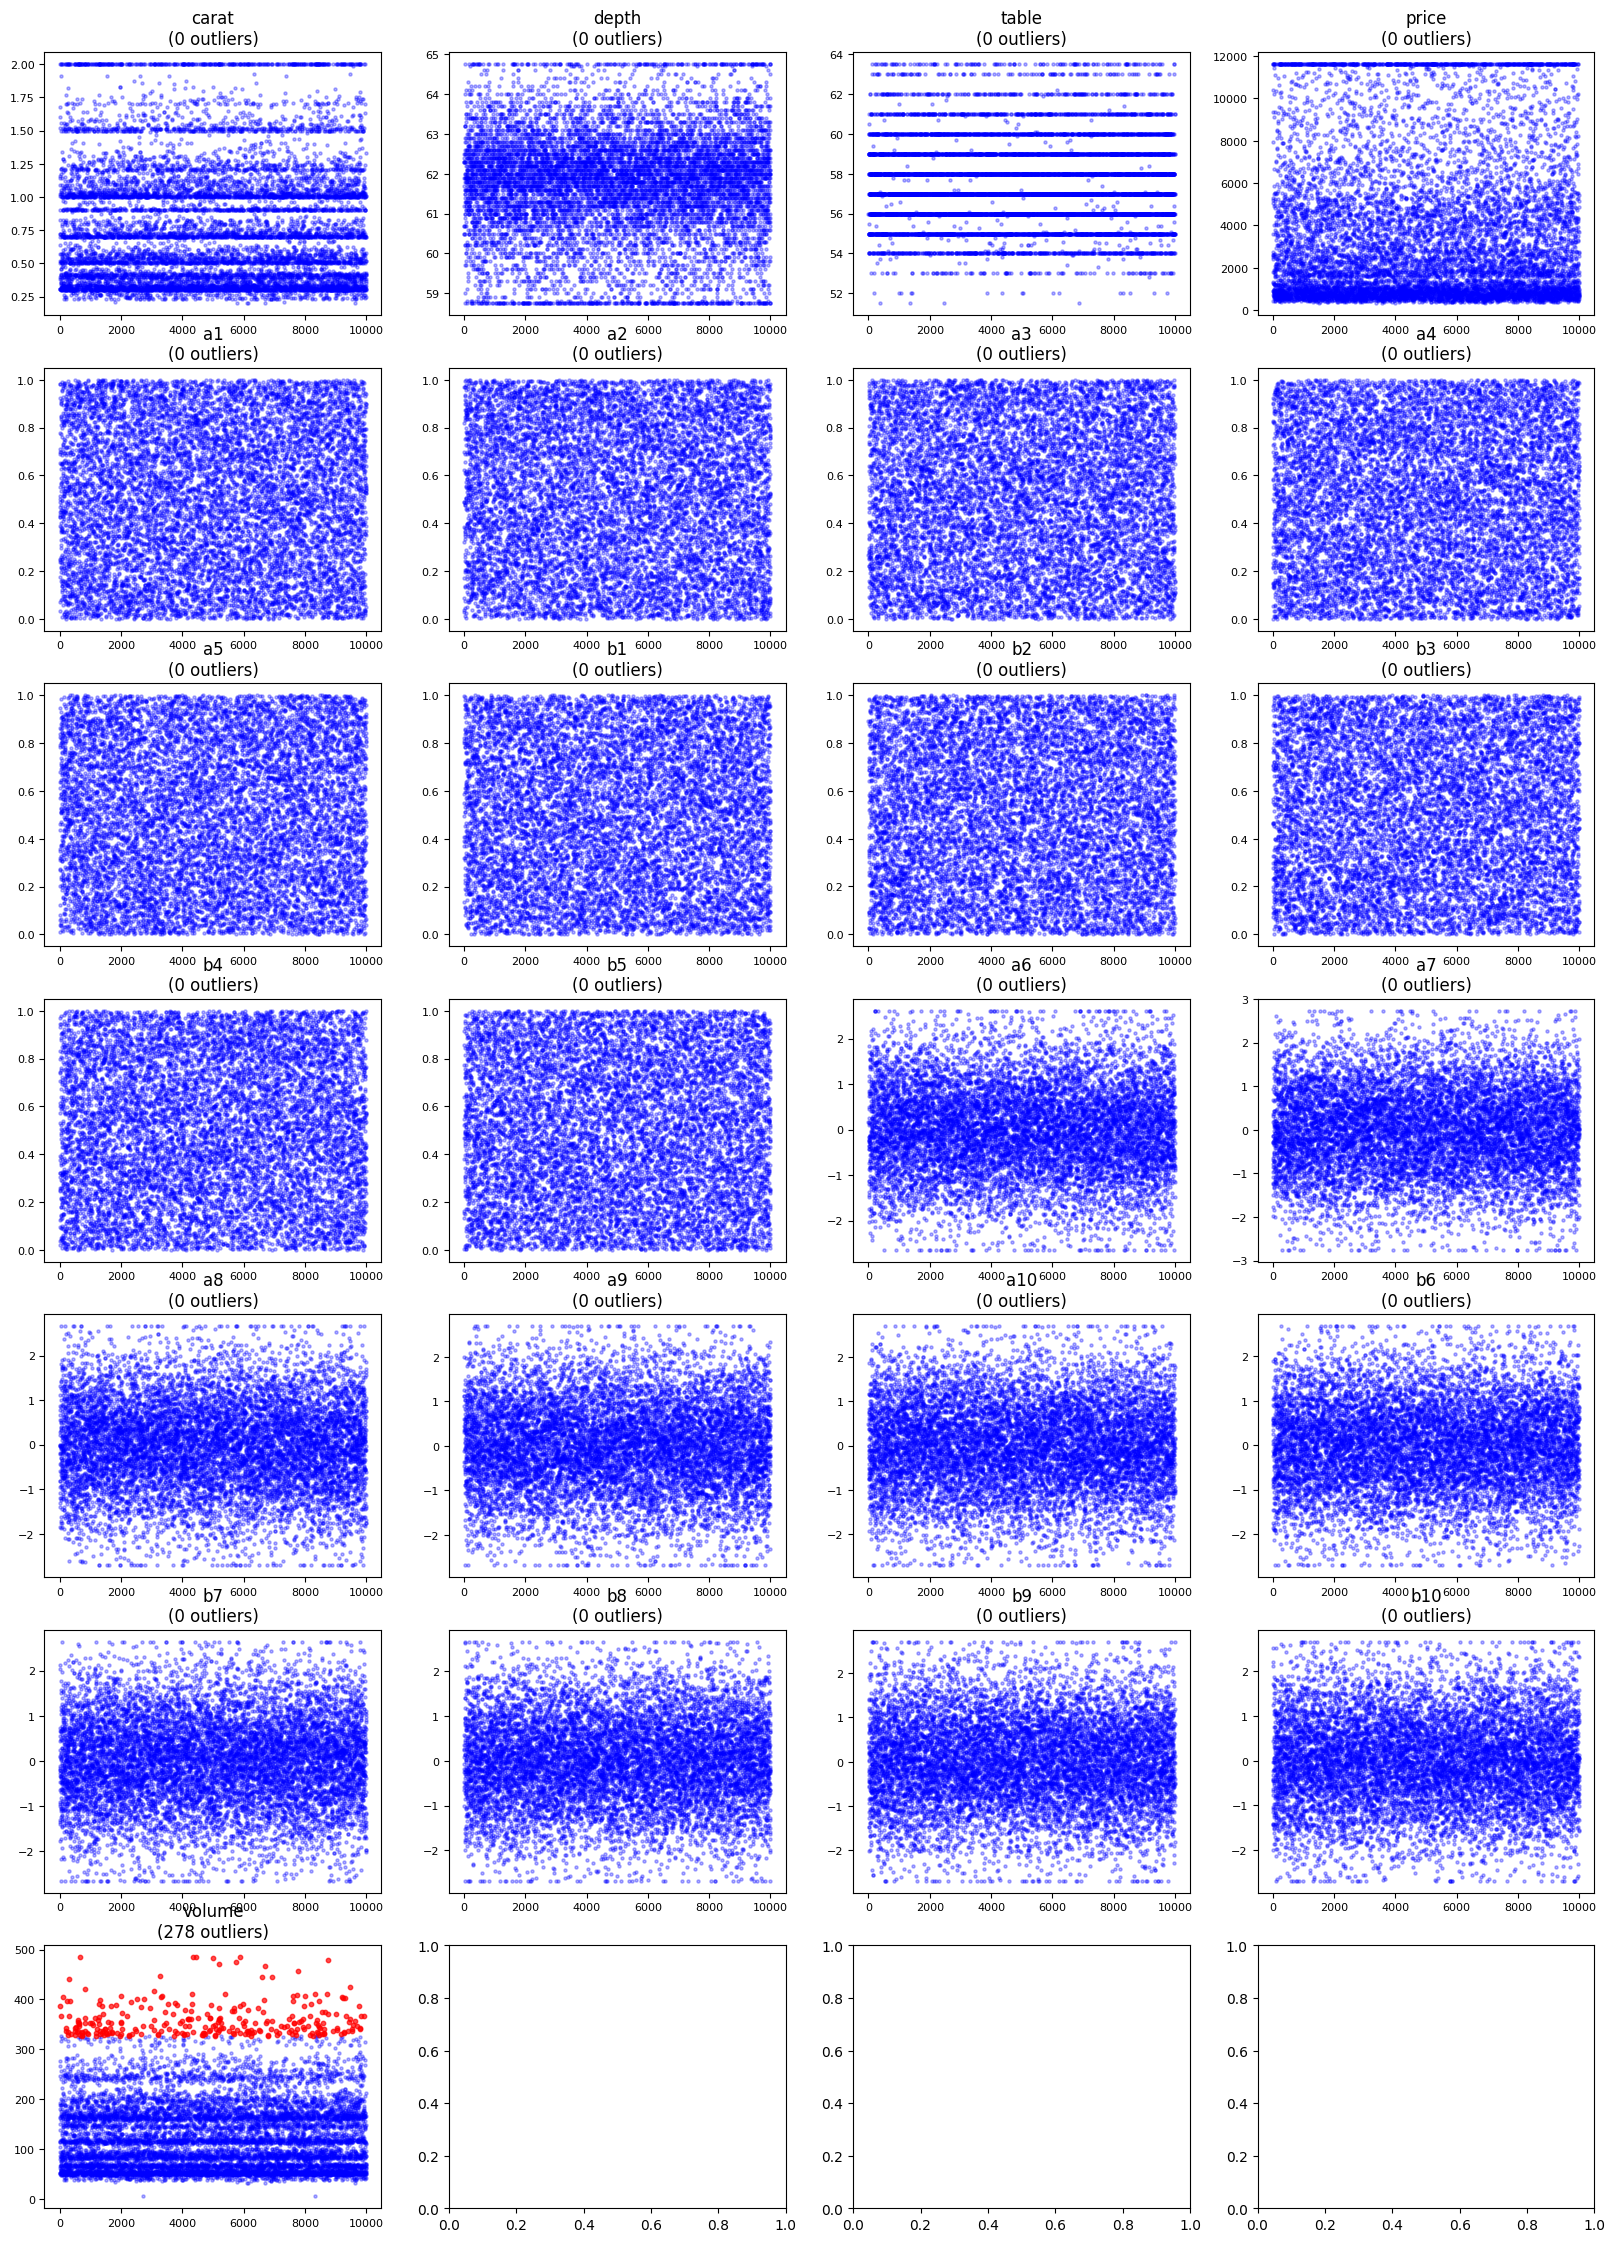

In [24]:
import matplotlib.pyplot as plt
# Creating a scatter plot to visualise potential outliers

num_cols = df.select_dtypes(include=[np.number]).columns.drop('outcome', errors='ignore')

n_cols = 4
n_rows = (len(num_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))
axes = axes.flatten()

print("Visualising Outliers (Red = Outlier, Blue = Normal)")

for i, col in enumerate(num_cols):
    data = df[col]

    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers using IQR
    is_outlier = (data < lower_bound) | (data > upper_bound)
    outlier_count = is_outlier.sum()

    # Plot features
    ax = axes[i]
    ax.scatter(df.index[~is_outlier], data[~is_outlier], c='blue', s=5, alpha=0.3, label='Normal')
    ax.scatter(df.index[is_outlier], data[is_outlier], c='red', s=10, alpha=0.7, label='Outlier')

    ax.set_title(f"{col}\n({outlier_count} outliers)")
    ax.tick_params(labelsize=8)

plt.show()

In [7]:
total_num_cols = df.select_dtypes(include=[np.number]).columns.drop('outcome', errors='ignore')

def cap_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # For outlier values cap to the upper or lower bound
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

df = cap_outliers_iqr(df, total_num_cols)

Outliers capped in columns: ['carat', 'depth', 'table', 'price', 'x', 'y', 'z', 'a1', 'a2', 'a3', 'a4', 'a5', 'b1', 'b2', 'b3', 'b4', 'b5', 'a6', 'a7', 'a8', 'a9', 'a10', 'b6', 'b7', 'b8', 'b9', 'b10']


In [8]:
# Creating a Volume feature
df['volume'] = df['x'] * df['y'] * df['z']

df = df.drop(columns=['x', 'y', 'z'])

In [9]:
target_col = "outcome"

X = df.drop(columns=[target_col])
y = df[target_col]

In [10]:
numeric_cols = X.select_dtypes(include=[np.number]).columns

In [11]:
corr_matrix = X[numeric_cols].corr().abs()
target_corr = X[numeric_cols].corrwith(y).abs()

In [12]:
selected_numeric = set(numeric_cols)
visited = set()

for col in numeric_cols:
    if col in visited:
        continue

    high_corr = corr_matrix.index[corr_matrix[col] >= 0.9].tolist()
    visited.update(high_corr)

    best_feature = target_corr[high_corr].idxmax()

    for f in high_corr:
        if f != best_feature and f in selected_numeric:
            selected_numeric.remove(f)

In [13]:
categorical_cols = X.select_dtypes(include=["object", "category"]).columns

X = X[list(selected_numeric) + list(categorical_cols)]

print("Final shape:", df.shape)

Final shape: (10000, 29)


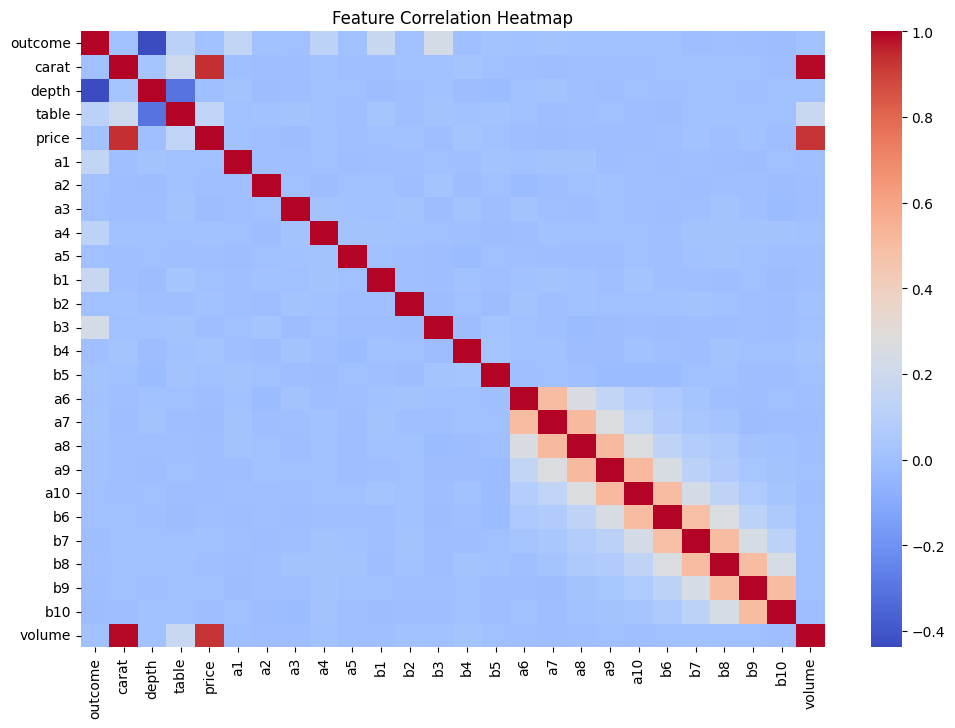

In [14]:
import seaborn as sns

# Select only numeric columns for the heatmap
numeric_df = df.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.savefig("correlation_heatmap.png")

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [16]:
ordinal_features = ["cut", "color", "clarity"]

ordinal_categories = [
    ["Fair", "Good", "Very Good", "Premium", "Ideal"],
    ["D", "E", "F", "G", "H", "I", "J"],
    ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
]

In [17]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns

In [18]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("ord", OrdinalEncoder(categories=ordinal_categories), ordinal_features)
    ]
)

**Training and Comparison of Models**

In [19]:
lr_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)
print("Linear Regression R2:", r2_score(y_test, y_pred))

Linear Regression R2: 0.293347331834503


In [20]:
rf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=100,
        random_state=42
    ))
])

from sklearn.model_selection import GridSearchCV

# Defining a grid of parameters
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5]
}

grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='r2', n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score (R2):", grid_search.best_score_)

# Evaluate on the held-out test set
best_model = grid_search.best_estimator_
test_preds = best_model.predict(X_test)
print("Final Test R2:", r2_score(y_test, test_preds))

Best Parameters: {'model__max_depth': 10, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best CV Score (R2): 0.4596590178787238
Final Test R2: 0.4382850151687414


In [21]:
nn_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", MLPRegressor(
        hidden_layer_sizes=(64, 32),
        max_iter=500,
        random_state=42
    ))
])

from sklearn.neural_network import MLPRegressor


param_grid_nn = {
    'model__hidden_layer_sizes': [(100,), (100, 50), (50, 50, 50)],
    'model__alpha': [0.0001, 0.05], # L2 penalty - regularization
    'model__learning_rate_init': [0.001, 0.01],
}


nn_grid = GridSearchCV(nn_model, param_grid_nn, cv=5, scoring='r2', n_jobs=-1)
nn_grid.fit(X_train, y_train)

print("Best NN Params:", nn_grid.best_params_)
print("Best NN CV R2:", nn_grid.best_score_)

Best NN Params: {'model__alpha': 0.05, 'model__hidden_layer_sizes': (100,), 'model__learning_rate_init': 0.001}
Best NN CV R2: 0.3407917249606004


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


**Evaluation and Submission**

the model needs to be retrained using one-hot encoding to ensure consistency with the evaluation script.

In [22]:
# Import training data
train_df = pd.read_csv("/content/drive/MyDrive/CW1_train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/CW1_test.csv")

# Cap outliers
train_df = cap_outliers_iqr(train_df, train_df.select_dtypes(include=[np.number]).columns.drop('outcome', errors='ignore'))
test_df = cap_outliers_iqr(test_df, test_df.select_dtypes(include=[np.number]).columns)

text_data_cols = ['cut', 'color', 'clarity']

# One-hot encode categorical variables
train_df = pd.get_dummies(train_df, columns=text_data_cols, drop_first=True)
test_df = pd.get_dummies(test_df, columns=text_data_cols, drop_first=True)

# Separate features from target column
X_train = train_df.drop(columns=["outcome"])
y_train = train_df["outcome"]

# Align test columns with training columns
test_df = test_df.reindex(columns=X_train.columns, fill_value=0)

# Train RF model with hyperparameters from previous grid search
best_model = RandomForestRegressor(
    n_estimators=grid_search.best_params_['model__n_estimators'],
    max_depth=grid_search.best_params_['model__max_depth'],
    min_samples_split=grid_search.best_params_['model__min_samples_split'],
    random_state=42
)

best_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=200,
                      random_state=42)

In [23]:
predictions = best_model.predict(test_df)
submission = pd.DataFrame({"yhat": predictions})
submission.to_csv(
    '/content/drive/MyDrive/nCW1_submission_k23006355.csv',
    index=False
)